In [1]:
import torch
import sys
import os
sys.path.insert(0,"/q/AVC-AI/jkshirsagar/CSI_Project/DiffusionXray-FewShot-LandmarkDetection/ddpm_pretraining")
from model.ddpm_model import DDPM

# Create 3D DDPM model
ddpm = DDPM(
    image_size=32,
    channels=1,
    device="cuda",
    is_3d=True
)

# Test forward pass
batch_size = 2
x = torch.randn(batch_size, 1, 32, 32, 32).cuda()
t = ddpm.sample_timesteps(batch_size)
loss = ddpm.p_losses(x, t)

print(f"Loss: {loss.item()}")

Loss: 0.7655060291290283


In [2]:
import torch
from ddpm_datasets import LUNA16DiffusionDataset
from torch.utils.data import DataLoader

# Test dataset loading
dataset = LUNA16DiffusionDataset(
    root_dir='/q/AVC-AI/jkshirsagar/CSI_Project/LUNA16',
    channels=1,
    volume_size=32,
    subset_ids=[0,1,2,3,4],
    phase='train'
)

print(f"Dataset size: {len(dataset)}")

LUNA16Dataset: Using GPU-accelerated MONAI transforms
LUNA16Dataset [train]: Loaded 445 CT scans
Dataset size: 445


In [3]:
# Test loading first item
data = dataset[0]
print(f"Sample name: {data['name']}")
print(f"Volume shape: {data['image'].shape}")
print(f"Volume range: [{data['image'].min():.3f}, {data['image'].max():.3f}]")

# Test dataloader
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

batch = next(iter(dataloader))
print(f"Batch shape: {batch['image'].shape}")

Sample name: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286
Volume shape: torch.Size([1, 32, 32, 32])
Volume range: [0.000, 1.000]
Batch shape: torch.Size([2, 1, 32, 32, 32])


In [1]:
import torch
import sys
import os
sys.path.insert(0,"/q/AVC-AI/jkshirsagar/CSI_Project/DiffusionXray-FewShot-LandmarkDetection/downstream_task")
from landmarks_datasets import LUNA16

# For landmark detection (nodule detection)
train_dataset = LUNA16(
    prefix='/q/AVC-AI/jkshirsagar/CSI_Project/LUNA16',
    phase='validate',
    size=(64, 64, 64),
    num_channels=1,
    sigma=4,
    fuse_heatmap=False
)

# Create data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

LUNA16 Landmark Dataset: Using GPU-accelerated MONAI transforms
LUNA16 validate dataset: 60 scans with landmarks, max 12 landmarks per scan
Total scans found: 88, Skipped (0 landmarks): 28


In [4]:
# Iterate to get the first batch
first_batch = next(iter(train_loader))

print("Keys in the first batch:")
if isinstance(first_batch, dict):
    # If the batch is a dictionary (common for custom datasets/dataloaders)
    for key, value in first_batch.items():
        print(f"  - Key: **{key}**")
        if isinstance(value, torch.Tensor):
            print(f"    - Type: {type(value)}")
            print(f"    - Shape: {list(value.shape)}")
            print(f"    - Size (total elements): {value.numel():,}")
        elif isinstance(value, list):
            # Handle cases where a key might contain a list (e.g., file paths, non-tensor metadata)
            print(f"    - Type: {type(value)}")
            print(f"    - Number of items: {len(value)}")
            if value and isinstance(value[0], torch.Tensor):
                print(f"    - Shape of first tensor: {list(value[0].shape)}")
        else:
            print(f"    - Type: {type(value)}")
            print(f"    - Value (first element if list): {value[0] if isinstance(value, list) and value else value}")

elif isinstance(first_batch, (list, tuple)):
    # If the batch is a list or tuple of Tensors (e.g., [data, target])
    print("Batch is a list or tuple of Tensors/items.")
    for i, item in enumerate(first_batch):
        print(f"  - Item Index: **{i}**")
        if isinstance(item, torch.Tensor):
            print(f"    - Type: {type(item)}")
            print(f"    - Shape: {list(item.shape)}")
            print(f"    - Size (total elements): {item.numel():,}")
        else:
            print(f"    - Type: {type(item)}")
            print(f"    - Content (first element if list): {item[0] if isinstance(item, list) and item else item}")

else:
    # Handle single tensor batches
    print("Batch is a single item/tensor.")
    if isinstance(first_batch, torch.Tensor):
        print(f"  - Type: {type(first_batch)}")
        print(f"  - Shape: {list(first_batch.shape)}")
        print(f"  - Size (total elements): {first_batch.numel():,}")
    else:
        print(f"  - Type: {type(first_batch)}")

Keys in the first batch:
  - Key: **name**
    - Type: <class 'list'>
    - Number of items: 1
  - Key: **image**
    - Type: <class 'monai.data.meta_tensor.MetaTensor'>
    - Shape: [1, 1, 64, 64, 64]
    - Size (total elements): 262,144
  - Key: **landmarks**
    - Type: <class 'torch.Tensor'>
    - Shape: [1, 12, 3]
    - Size (total elements): 36
  - Key: **num_valid_landmarks**
    - Type: <class 'torch.Tensor'>
    - Shape: [1]
    - Size (total elements): 1
  - Key: **heatmaps**
    - Type: <class 'torch.Tensor'>
    - Shape: [1, 12, 64, 64, 64]
    - Size (total elements): 3,145,728
  - Key: **original_size**
    - Type: <class 'torch.Tensor'>
    - Shape: [1, 3]
    - Size (total elements): 3
  - Key: **resized_size**
    - Type: <class 'torch.Tensor'>
    - Shape: [1, 3]
    - Size (total elements): 3
  - Key: **origin**
    - Type: <class 'torch.Tensor'>
    - Shape: [1, 3]
    - Size (total elements): 3
  - Key: **spacing**
    - Type: <class 'torch.Tensor'>
    - Shape: [1

=== Debug Info ===
Image shape: (64, 64, 64), range: [0.000, 1.000]
Heatmaps shape: (12, 64, 64, 64), range: [0.0000, 1.0000]
Num valid landmarks: 1
Volume size: [64. 64. 64.]
Landmark 0: normalized=(0.786, 0.545, 0.287) -> voxel=(z=50.3, y=34.9, x=18.4)
  Heatmap 0 value at landmark: 0.9752, max: 1.0000

Visualizing slices: z=50, y=34, x=18


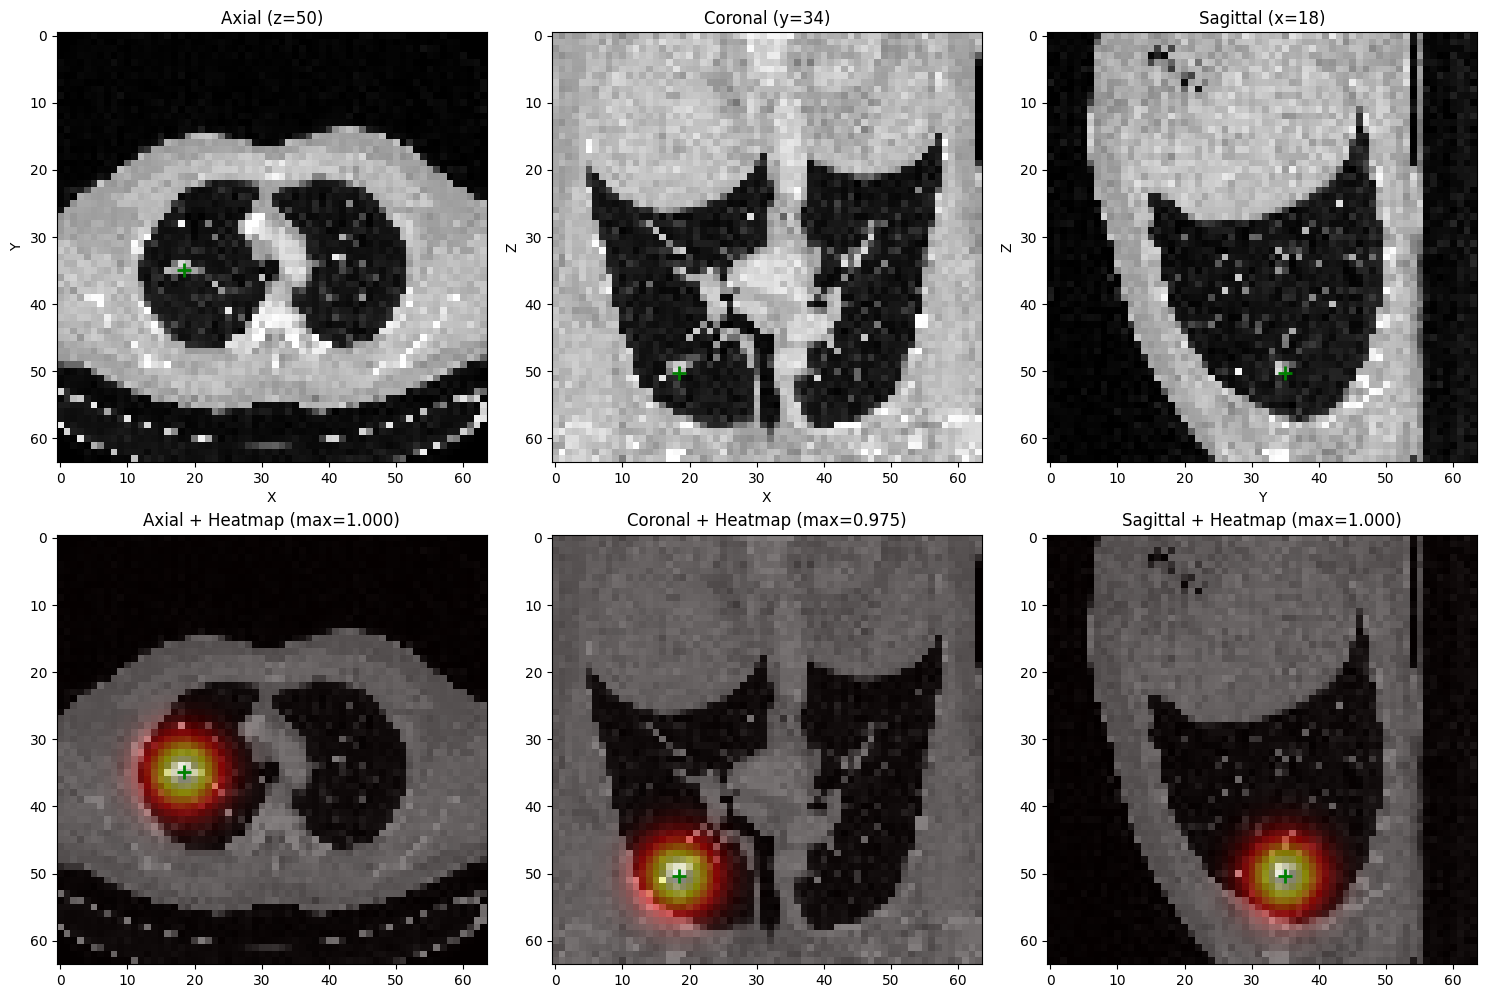

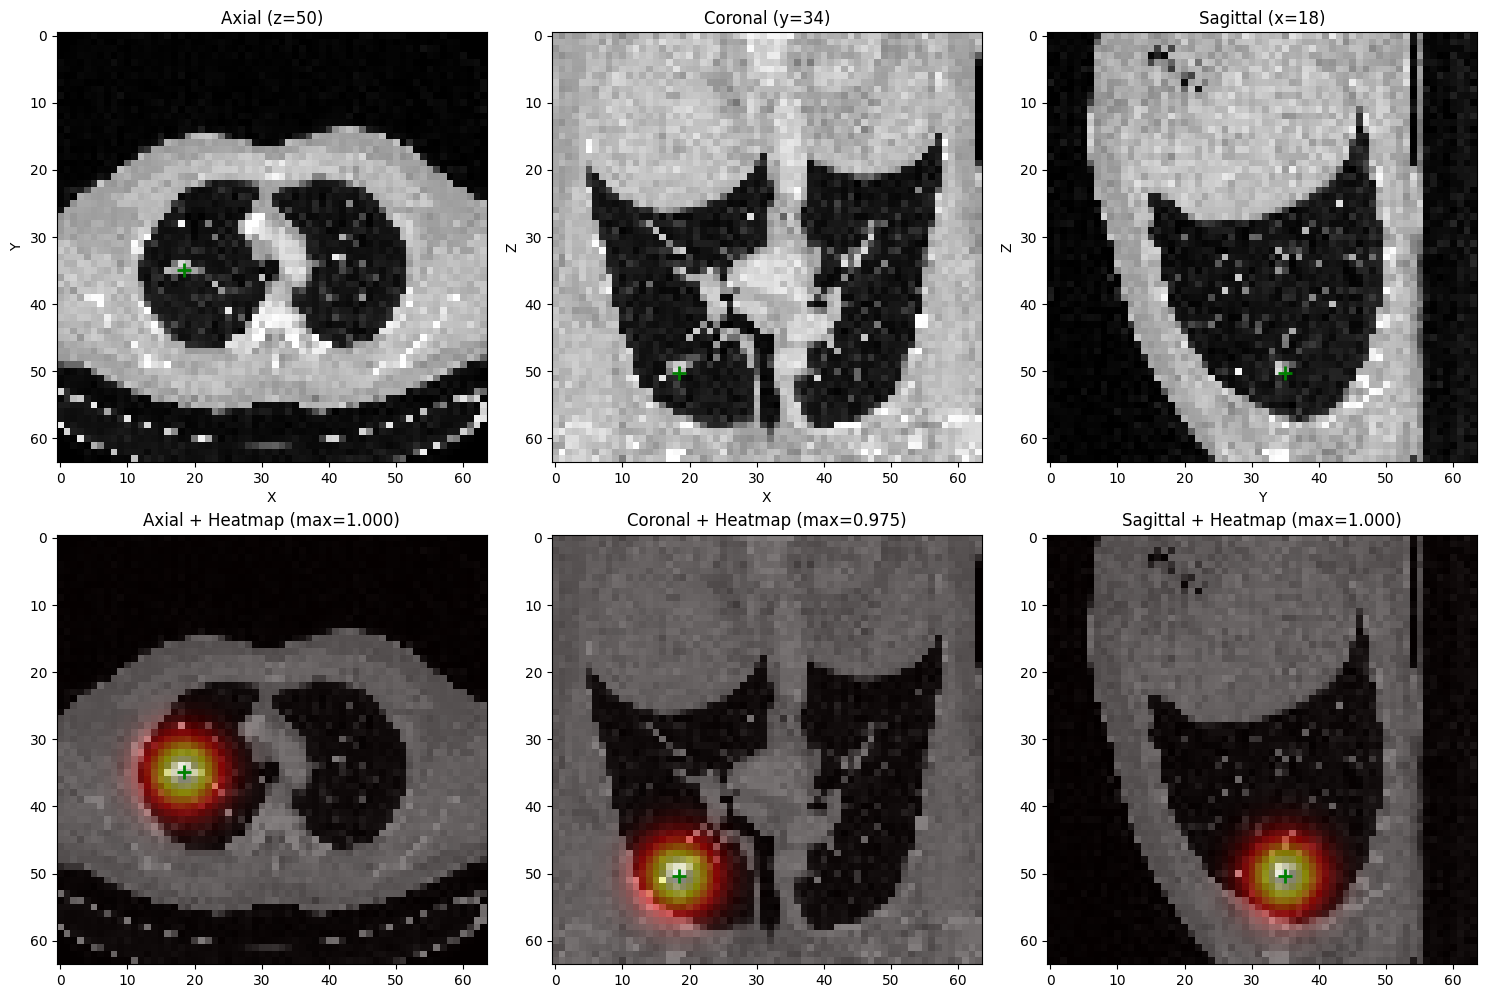

In [3]:
import utilities
sample = train_dataset[3]
# Debug visualization
utilities.debug_landmark_heatmap_3d(sample)

# # Or enable debug in heatmap generation
# points_test = np.array([[32, 32, 32], [16, 48, 24]])  # Already in voxel coords
# heatmaps = utilities.points_to_heatmap_3d(
#     points_test, 
#     vol_size=(64, 64, 64), 
#     sigma=2, 
#     debug=True
# )